# Building a Convolutional Neural Net to Perform Sentiment Analysis on Amazon Product Reviews

#### Project by Jacob Zimmer <br>
 - Github: https://github.com/zimmerja11 <br>
 - Portfolio Website: https://zimmerja11.github.io/portfolio/past_projects.html (This project coming soon...)

In [112]:
import numpy as np
import pandas as pd
import re
import random
import matplotlib.pyplot as plt
from collections import defaultdict

import nltk
import string
from nltk.corpus import stopwords

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

import bz2
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.utils import shuffle

import keras
from keras.layers import *
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers
from keras.callbacks import History


## Read and Preprocess Train and Test Data

In [2]:
train_file = bz2.BZ2File('train.ft.txt.bz2')
test_file = bz2.BZ2File('test.ft.txt.bz2')

In [3]:
# Create lists of sentences from train and test data, and convert to parsable strings
train_lines = train_file.readlines()
test_lines = test_file.readlines()
train_lines_clean = [x.decode('utf-8') for x in train_lines]
test_lines_clean = [x.decode('utf-8') for x in test_lines]

# Data format: __label__<X> __label__<Y> ... <Text>
# label 1 = 1/2 star review, label 2 = 4/5 star review
# 3 star (a.k.a. neutral sentiment) reviews were not included in dataset

In [4]:
def preprocess(rev_ls):
    text = []
    ratings = []
    for line in tqdm(rev_ls):
        
        # split rating from text and normalize text to lowercase
        sp = line.split(' ', 1)
        rev = sp[1].lower()
        
        # if rating is negative (1 or 2), assign dummy variable of 0
        if (sp[0] == '__label__1'):
            ratings.append(0)
        
        # if rating is positive (3 or 4), assign dummy variable of 1
        else:
            ratings.append(1)
            
        # clean numbers and urls from text
        rev = re.sub('\d', '0', rev)
        rev = re.sub('(?:(?:https?|ftp|file):\/\/|www\.|ftp\.)(?:\([-A-Z0-9+&@#\/%=~_|$?!:,.]*\)|[-A-Z0-9+&@#\/%=~_|$?!:,.])*(?:\([-A-Z0-9+&@#\/%=~_|$?!:,.]*\)|[A-Z0-9+&@#\/%=~_|$])', '<url>', rev)
        
        text.append(rev)
    
    return text, ratings

In [5]:
train_text, train_ratings = preprocess(train_lines_clean)

100%|██████████| 3600000/3600000 [01:17<00:00, 46508.54it/s]


In [8]:
combined = list(zip(train_text, train_ratings))
random.shuffle(combined)

train_text, train_ratings = zip(*combined)

In [9]:
test_text, test_ratings = preprocess(test_lines_clean)

100%|██████████| 400000/400000 [00:07<00:00, 51283.35it/s]


In [10]:
combined2 = list(zip(test_text, test_ratings))
random.shuffle(combined2)

test_text, test_ratings = zip(*combined2)

In [11]:
train_ratings = np.array(train_ratings)
test_ratings = np.array(test_ratings)

In [16]:
train_text[0]

"great product: bought this for my 0 year old daughter when she started to learn to swim. a great product and works as described. it's nice because it's adjustable and all the foam pads are removeable so you can adjust as the child progresses.\n"

#### Now that the data has been cleaned and shuffled, ready to begin testing NN architectures

### Create several Neural Net architectures wrapped in classes for testing

In [76]:
def large_functional_api(max_len, max_feat, embed_sz, lr):
    input = Input(shape=(max_len,))
    net = Embedding(max_feat, embed_sz)(input) #word embeddings rather than one-hot encoding to save on computational costs
    net = Dropout(0.2)(net) #ignore randomly selected 20% of nodes to regularize and prevent overfitting https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
    net = BatchNormalization()(net) #normalize activation layers to have mean activation close to 0 and the activation standard deviation close to 1.
        # ^standardizes the inputs of the model
    net = Conv1D(32, 7, padding='same', activation='relu')(net) 
    net = BatchNormalization()(net)
    net = Conv1D(32, 3, padding='same', activation='relu')(net)
    net = BatchNormalization()(net)
    net = Conv1D(32, 3, padding='same', activation='relu')(net)
    net = BatchNormalization()(net)
    net = Conv1D(32, 3, padding='same', activation='relu')(net)
    net = BatchNormalization()(net)

    net = Conv1D(2, 1)(net)
    net = GlobalAveragePooling1D()(net) 
    output = Activation('softmax')(net)
    model = Model(inputs = input, outputs = output)
    opt = keras.optimizers.Adam(lr=lr)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model

In [77]:
def med_functional_api(max_len, max_feat, embed_sz, lr):
    input = Input(shape=(max_len,))
    net = Embedding(max_feat, embed_sz)(input)
    net = Dropout(0.2)(net) 
    net = BatchNormalization()(net)
    net = Conv1D(32, 7, padding='same', activation='relu')(net) 
    net = BatchNormalization()(net)
    net = Conv1D(32, 3, padding='same', activation='relu')(net)
    net = BatchNormalization()(net)
    net = Conv1D(32, 3, padding='same', activation='relu')(net)
    net = BatchNormalization()(net)

    net = Conv1D(2, 1)(net)
    net = GlobalAveragePooling1D()(net) 
    output = Activation('softmax')(net)
    model = Model(inputs = input, outputs = output)
    opt = keras.optimizers.Adam(lr=lr)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model

In [61]:
# def small_functional_api(max_len, max_feat, embed_sz):
#     input = Input(shape=(max_len,))
#     net = Embedding(max_feat, embed_sz)(input) #word embeddings rather than one-hot encoding to save on computational costs
#     net = Dropout(0.2)(net) #ignore randomly selected 20% of nodes to regularize and prevent overfitting https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
#     net = BatchNormalization()(net) #normalize activation layers to have mean activation close to 0 and the activation standard deviation close to 1.
#         # ^standardizes the inputs of the model
#     net = Conv1D(16, 7, padding='same', activation='relu')(net) 
#     net = BatchNormalization()(net)
#     net = Conv1D(16, 3, padding='same', activation='relu')(net)
#     net = BatchNormalization()(net)
#     net = Conv1D(16, 3, padding='same', activation='relu')(net)
#     net = BatchNormalization()(net)

#     net = Conv1D(2, 1)(net)
#     net = GlobalAveragePooling1D()(net) 
#     output = Activation('softmax')(net)
#     model = Model(inputs = input, outputs = output)
#     opt = Adam(lr=lr)
#     model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
#     return model

### Create and Populate lists of parameters to test

In [78]:
test_lr = [0.007, 0.01, 0.013]
test_max_lens = [128, 200]
test_max_feats = [8000, 10000]

### Test Parameters and NN Architectures

In [79]:
summary_hist = defaultdict(list)
for num in tqdm(range(2)):
    
    # Construct and fit tokenizer
    print('TOKENIZING ################')
    tokenizer = Tokenizer(num_words=test_max_feats[num])
    tokenizer.fit_on_texts(train_text)
    
    # Convert texts to sequences for test and train sets
    token_train = tokenizer.texts_to_sequences(train_text)
    token_test = tokenizer.texts_to_sequences(test_text)
    
    # Normalize list lengths with pad_sequences
    print('NORMALIZING ###############')
    token_train_rev = pad_sequences(token_train, maxlen=test_max_lens[num], padding='post')
    token_test_rev = pad_sequences(token_test, maxlen=test_max_lens[num], padding='post')
    
    # Build large model with given test inputs
    print('LARGE: BEGIN *****************')
    history = History()
    large_model = large_functional_api(test_max_lens[num], test_max_feats[num], embed_size, 0.01)
    
    # Fit large model
    large_model.fit(token_train_rev, train_ratings, batch_size=2048, epochs=2, validation_split=0.1, callbacks=[history])
    
    # Save large model summary
    summary_hist['large'].append(large_model.summary)
    
    # Evaluate large model
    large_model.evaluate(token_test_rev, test_ratings)
    
    # Save large model history
    summary_hist['large'].append(history.history)
    print('LARGE: END *******************')
    
    # Build medium model with given test inputs
    print('MED: BEGIN *****************')
    history = History()
    med_model = med_functional_api(test_max_lens[num], test_max_feats[num], embed_size, 0.01)
    
    # Fit medium model
    med_model.fit(token_train_rev, train_ratings, batch_size=2048, epochs=2, validation_split=0.1, callbacks=[history])
    
    # Save medium model summary
    summary_hist['med'].append(med_model.summary)
    
    # Evaluate medium model
    med_model.evaluate(token_test_rev, test_ratings)
    
    # Save large model history
    summary_hist['med'].append(history.history)
    print('MED: END *******************')



  0%|          | 0/2 [00:00<?, ?it/s]

TOKENIZING ################
NORMALIZING ###############
LARGE: BEGIN *****************
Train on 3240000 samples, validate on 360000 samples
Epoch 1/2
3240000/3240000 [==============================] - 2983s 921us/step - loss: 0.1786 - acc: 0.9323 - val_loss: 0.1566 - val_acc: 0.9422
Epoch 2/2
400000/400000 [==============================] - 117s 293us/step
LARGE: END *******************
MED: BEGIN *****************
Train on 3240000 samples, validate on 360000 samples
Epoch 1/2
3240000/3240000 [==============================] - 3115s 961us/step - loss: 0.1783 - acc: 0.9324 - val_loss: 0.1609 - val_acc: 0.9399
Epoch 2/2
400000/400000 [==============================] - 109s 272us/step


MED: END *******************


 50%|█████     | 1/2 [3:45:45<3:45:45, 13545.53s/it]

TOKENIZING ################
NORMALIZING ###############
LARGE: BEGIN *****************
Train on 3240000 samples, validate on 360000 samples
Epoch 1/2
3240000/3240000 [==============================] - 4582s 1ms/step - loss: 0.1679 - acc: 0.9370 - val_loss: 0.1580 - val_acc: 0.9430
Epoch 2/2
400000/400000 [==============================] - 180s 450us/step
LARGE: END *******************
MED: BEGIN *****************
Train on 3240000 samples, validate on 360000 samples
Epoch 1/2
3240000/3240000 [==============================] - 3954s 1ms/step - loss: 0.1670 - acc: 0.9376 - val_loss: 0.1590 - val_acc: 0.9398
Epoch 2/2
400000/400000 [==============================] - 171s 428us/step


MED: END *******************


100%|██████████| 2/2 [9:09:46<00:00, 15314.19s/it]  



In [80]:
med_model.evaluate(token_test_rev, test_ratings)

400000/400000 [==============================] - 163s 407us/step


[0.1444628765979316, 0.9492375]

In [81]:
large_model.evaluate(token_test_rev, test_ratings)

400000/400000 [==============================] - 182s 455us/step


[0.19689987221751362, 0.92202]

In [84]:
summary_hist['large']

[<bound method Network.summary of <keras.engine.training.Model object at 0x1defa04a8>>,
 {'val_loss': [0.15660430637200673, 0.16228238769637213],
  'val_acc': [0.9421611112276713, 0.9384694443808661],
  'loss': [0.17855826904332198, 0.1522252820858249],
  'acc': [0.9322774691358025, 0.9440077160493827]},
 <bound method Network.summary of <keras.engine.training.Model object at 0x3e063feb8>>,
 {'val_loss': [0.15801503590212929, 0.1946069554037518],
  'val_acc': [0.9430250000953674, 0.9231861111746894],
  'loss': [0.16786271585652857, 0.14187300804073427],
  'acc': [0.9370280864197531, 0.9484003086419753]}]

In [85]:
summary_hist['med']

[<bound method Network.summary of <keras.engine.training.Model object at 0x1c0d20e10>>,
 {'val_loss': [0.16091600964599184, 0.15198128884368473],
  'val_acc': [0.9398555555343628, 0.9444277777671813],
  'loss': [0.1782507532508285, 0.15142749178792222],
  'acc': [0.9324030864197531, 0.9443148148148148]},
 <bound method Network.summary of <keras.engine.training.Model object at 0x1e360ff98>>,
 {'val_loss': [0.158955430454678, 0.14349026083681318],
  'val_acc': [0.9397694443808662, 0.9492694443278843],
  'loss': [0.16702320119010078, 0.14077126667190482],
  'acc': [0.9376302469135802, 0.948866975308642]}]

#### According to our tests, the best model is a medium-sized model with max_features = 10000, maxlen = 200

### Re-construct model with optimal parameters for testing learning rate parameter values

In [89]:
max_features = 10000 # vocab size of the dataset to be used in NN
maxlen = 200 # number of words taken from each review for use in NN 
embed_size = 64 # size of output matrix

In [90]:
# Construct and fit tokenizer
print("TOKENIZING")
tokenizer = Tokenizer(num_words=max_features) # initialize tokenizer to consider only top the "max_features" most frequent tokens
tokenizer.fit_on_texts(train_text) # fit on
    
# Vectorize texts in both test and train sets
token_train = tokenizer.texts_to_sequences(train_text) # vectorize each text in corpus; convert each text in in train_text to a sequence of integers
token_test = tokenizer.texts_to_sequences(test_text)

print("NORMALIZING")
# Normalize list lengths with pad_sequences
token_train_rev = pad_sequences(token_train, maxlen=maxlen, padding='post') # pad train and test vectors with 0's to ensure all vectors are of matching length (so that the math checks out)
token_test_rev = pad_sequences(token_test, maxlen=maxlen, padding='post')

med_hist = []
for num in tqdm(range(3)):

    print("BEGIN ", num, "*****************")
    # Build medium model with given test inputs
    history = History()
    med_model = med_functional_api(maxlen, max_features, embed_size, test_lr[num])
    
    # Fit medium model
    med_model.fit(token_train_rev, train_ratings, batch_size=2048, epochs=3, validation_split=0.1, callbacks=[history])

    #save model summary
    med_hist.append(med_model.summary)
    
    #evaluate model and save
    med_hist.append(med_model.evaluate(token_test_rev, test_ratings))
    
    #save model history
    med_hist.append(history.history)

TOKENIZING
NORMALIZING




  0%|          | 0/3 [00:00<?, ?it/s]

BEGIN  0 *****************
Train on 3240000 samples, validate on 360000 samples
Epoch 1/3
3240000/3240000 [==============================] - 5551s 2ms/step - loss: 0.1676 - acc: 0.9373 - val_loss: 0.1684 - val_acc: 0.9399
Epoch 2/3
3240000/3240000 [==============================] - 3882s 1ms/step - loss: 0.1407 - acc: 0.9490 - val_loss: 0.1426 - val_acc: 0.9486
Epoch 3/3
400000/400000 [==============================] - 175s 438us/step




 33%|███▎      | 1/3 [3:44:54<7:29:48, 13494.16s/it]

BEGIN  1 *****************
Train on 3240000 samples, validate on 360000 samples
Epoch 1/3
3240000/3240000 [==============================] - 3855s 1ms/step - loss: 0.1717 - acc: 0.9355 - val_loss: 0.1482 - val_acc: 0.9452
Epoch 2/3
3240000/3240000 [==============================] - 3834s 1ms/step - loss: 0.1430 - acc: 0.9480 - val_loss: 0.1949 - val_acc: 0.9267
Epoch 3/3
400000/400000 [==============================] - 182s 454us/step




 67%|██████▋   | 2/3 [6:59:58<3:35:57, 12957.29s/it]

BEGIN  2 *****************
Train on 3240000 samples, validate on 360000 samples
Epoch 1/3
3240000/3240000 [==============================] - 3824s 1ms/step - loss: 0.1709 - acc: 0.9359 - val_loss: 0.1484 - val_acc: 0.9455
Epoch 2/3
3240000/3240000 [==============================] - 3858s 1ms/step - loss: 0.1430 - acc: 0.9480 - val_loss: 0.1468 - val_acc: 0.9468
Epoch 3/3
400000/400000 [==============================] - 176s 440us/step




100%|██████████| 3/3 [10:14:40<00:00, 12574.76s/it] 



In [91]:
med_hist

[<bound method Network.summary of <keras.engine.training.Model object at 0x1e4388ef0>>,
 [0.14174115764457731, 0.949015],
 {'val_loss': [0.16840485956403944, 0.14264966451327005, 0.14017751517560748],
  'val_acc': [0.9398722221692403, 0.94861944448683, 0.9494083332061768],
  'loss': [0.1675738401973689, 0.14065540144708422, 0.1326551035368884],
  'acc': [0.9372885802469135, 0.9489518518518518, 0.9521003086419753]},
 <bound method Network.summary of <keras.engine.training.Model object at 0x1db3985c0>>,
 [0.16019020637750625, 0.94062],
 {'val_loss': [0.14821593182351855, 0.19487563123173185, 0.15884031810230678],
  'val_acc': [0.945238888920678, 0.9266694444656373, 0.9410166667514377],
  'loss': [0.1716884000580988, 0.14295279691778584, 0.13450842249246292],
  'acc': [0.9354521604938272, 0.9479737654320988, 0.9513351851851852]},
 <bound method Network.summary of <keras.engine.training.Model object at 0x1e9037e10>>,
 [0.1434065641307831, 0.94787],
 {'val_loss': [0.148443026248614, 0.14682

#### According to this test, the optimal learn_rate for our model is 0.007 (default is 0.1)

### Re-construction of the model with optimal parameters for testing number of epochs

In [100]:
learn_rt = 0.007

In [92]:
# Construct and fit tokenizer
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_text)

# Convert texts to sequences for test and train sets
token_train = tokenizer.texts_to_sequences(train_text)
token_test = tokenizer.texts_to_sequences(test_text)

# Normalize list lengths with pad_sequences
token_train_rev = pad_sequences(token_train, maxlen=maxlen, padding='post')
token_test_rev = pad_sequences(token_test, maxlen=maxlen, padding='post')

In [95]:
# Build medium model with given test inputs
history = History()
med_model = med_functional_api(maxlen, max_features, embed_size, learn_rt)
    
# Fit medium model
med_model.fit(token_train_rev, train_ratings, batch_size=2048, epochs=6, validation_split=0.1, callbacks=[history])

Train on 3240000 samples, validate on 360000 samples
Epoch 1/6
3240000/3240000 [==============================] - 4005s 1ms/step - loss: 0.1693 - acc: 0.9367 - val_loss: 0.1511 - val_acc: 0.9436
Epoch 2/6
3240000/3240000 [==============================] - 3841s 1ms/step - loss: 0.1422 - acc: 0.9481 - val_loss: 0.1862 - val_acc: 0.9318
Epoch 3/6
3240000/3240000 [==============================] - 3839s 1ms/step - loss: 0.1344 - acc: 0.9513 - val_loss: 0.1581 - val_acc: 0.9406
Epoch 4/6
3240000/3240000 [==============================] - 3844s 1ms/step - loss: 0.1284 - acc: 0.9537 - val_loss: 0.1424 - val_acc: 0.9494
Epoch 5/6
3240000/3240000 [==============================] - 3844s 1ms/step - loss: 0.1240 - acc: 0.9553 - val_loss: 0.1424 - val_acc: 0.9480
Epoch 6/6
3240000/3240000 [==============================] - 3869s 1ms/step - loss: 0.1201 - acc: 0.9569 - val_loss: 0.1416 - val_acc: 0.9500


In [96]:
#show model summary
med_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 200)               0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 200, 64)           640000    
_________________________________________________________________
dropout_15 (Dropout)         (None, 200, 64)           0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 200, 64)           256       
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 200, 32)           14368     
_________________________________________________________________
batch_normalization_62 (Batc (None, 200, 32)           128       
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 200, 32)           3104      
__________

In [98]:
#evaluate model
med_model.evaluate(token_test_rev, test_ratings)

400000/400000 [==============================] - 177s 443us/step


[0.14302790888627992, 0.949625]

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


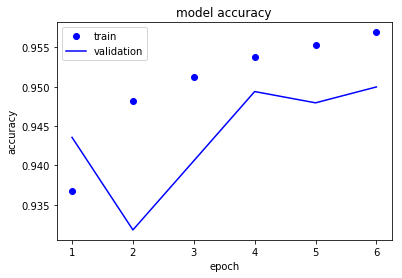

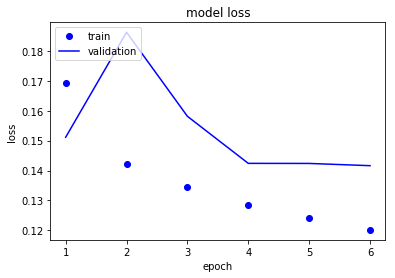

In [104]:
print(history.history.keys())
#  "Accuracy"
plt.plot(range(1, len(history.history['loss']) + 1), history.history['acc'], 'bo', label="Training acc")
plt.plot(range(1, len(history.history['loss']) + 1), history.history['val_acc'], 'b', label="Validation acc")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], 'bo', label="Training loss")
plt.plot(range(1, len(history.history['loss']) + 1), history.history['val_loss'], 'b', label="Validation loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### The goal for a NN is to maximize validation accuracy and minimize validation loss. Thus, seeing the simultaneous peaking of the validation accuracy and flattening of the validation loss at 4 epochs, we know that 4 is the optimal number of epochs (any more will cause overfitting to the training data).

## Construct and Evaluate Final CNN

In [107]:
# Build medium model with given test inputs
history2 = History()
med_model2 = med_functional_api(maxlen, max_features, embed_size, 0.01)
    
# Fit medium model
med_model2.fit(token_train_rev, train_ratings, batch_size=2048, epochs=4, validation_split=0.1, callbacks=[history2])

Train on 3240000 samples, validate on 360000 samples
Epoch 1/4
3240000/3240000 [==============================] - 3857s 1ms/step - loss: 0.1716 - acc: 0.9356 - val_loss: 0.1489 - val_acc: 0.9453
Epoch 2/4
3240000/3240000 [==============================] - 7716s 2ms/step - loss: 0.1427 - acc: 0.9483 - val_loss: 0.1446 - val_acc: 0.9469
Epoch 3/4
3240000/3240000 [==============================] - 8381s 3ms/step - loss: 0.1345 - acc: 0.9515 - val_loss: 0.1409 - val_acc: 0.9501
Epoch 4/4
3240000/3240000 [==============================] - 4258s 1ms/step - loss: 0.1287 - acc: 0.9538 - val_loss: 0.1602 - val_acc: 0.9402


In [108]:
#show model summary
med_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 200)               0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 200, 64)           640000    
_________________________________________________________________
dropout_18 (Dropout)         (None, 200, 64)           0         
_________________________________________________________________
batch_normalization_73 (Batc (None, 200, 64)           256       
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 200, 32)           14368     
_________________________________________________________________
batch_normalization_74 (Batc (None, 200, 32)           128       
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 200, 32)           3104      
__________

In [109]:
#evaluate model
med_model2.evaluate(token_test_rev, test_ratings)

400000/400000 [==============================] - 196s 490us/step


[0.16153441132627427, 0.93959]

dict_keys([])


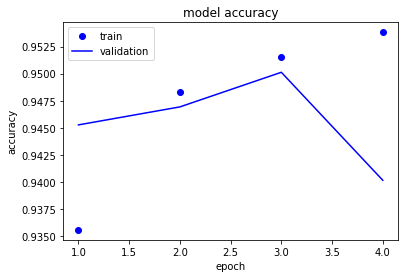

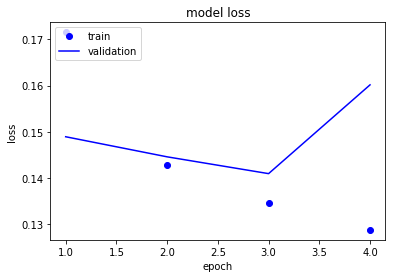

In [111]:
print(history.history.keys())
#  "Accuracy"
plt.plot(range(1, len(history2.history['loss']) + 1), history2.history['acc'], 'bo', label="Training acc")
plt.plot(range(1, len(history2.history['loss']) + 1), history2.history['val_acc'], 'b', label="Validation acc")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(range(1, len(history2.history['loss']) + 1), history2.history['loss'], 'bo', label="Training loss")
plt.plot(range(1, len(history2.history['loss']) + 1), history2.history['val_loss'], 'b', label="Validation loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### Based on the results of the evaluation, as well as the graphs of accuracy and loss for the model, we see that our model performs quite well, with a test accuracy of ~94% and a test loss of ~16. That said, we still see a peaking behavior in validation accuracy and a rise in validation loss around epoch 3; This can likely be attributed to the small epoch size causing fluctuation in the results, but (due to current time restraints) I will leave the testing of 3 epochs for the future.

### Word Embeddings Visualization using t-SNE

In [115]:
# Get weights
conv_embds = med_model2.layers[1].get_weights()[0]

In [119]:
w_ls = []
for word, i in tokenizer.word_index.items():
    w_ls.append(word)

In [172]:
# Plotting function
def plot_words(data, start, stop, step, word_list):
    trace = go.Scatter(
        x = data[start:stop:step,0], 
        y = data[start:stop:step, 1],
        mode = 'markers',
        text= word_list[start:stop:step]
    )
#     trace2 = go.Scatter(
#         x = [22.29426,-3.560344, -0.5570806, 60.73775, 58.53597,-0.7551264,0.2208699,53.87415,50.27823],
#         y = [-30.57199,-22.06865,-24.81901,-2.160184,-5.735543,7.880981,9.620249,6.937816,3.089232],
#         mode='markers+text',
#         text=['camera','films','photos', 'video', 'documentary', 'published', 'book', 'cats', 'animals'],
#         textposition = 'bottom',
#         textfont=dict(size=16, color='#DF0101')
#     )
    layout = dict(title= 't-SNE 1 vs t-SNE 2',
                  yaxis = dict(title='t-SNE 2'),
                  xaxis = dict(title='t-SNE 1'),
                  hovermode= 'closest')
    fig = dict(data = [trace], layout= layout)#[trace, trace2], layout= layout)
    py.iplot(fig)

In [122]:
# Visualize words in two dimensions 
conv_tsne_embds = TSNE(n_components=2).fit_transform(conv_embds)

In [173]:
plot_words(conv_tsne_embds, 0, 2000, 1, w_ls)

## Generate Review Predictions using Final Model

#### Positive Review Prediction example

In [205]:
good = 0
train_text[good], train_ratings[good] #1 = good, 0 = bad

("great product: bought this for my 0 year old daughter when she started to learn to swim. a great product and works as described. it's nice because it's adjustable and all the foam pads are removeable so you can adjust as the child progresses.\n",
 1)

In [206]:
ex1 = tokenizer.texts_to_sequences(train_text[good])
ex1 = pad_sequences(ex1, maxlen=maxlen, padding='post')
prediction = med_model2.predict(np.array(ex1))
class_pred = prediction.argmax(axis=-1)
print(class_pred[0])

1


#### Negative Review Prediction example

In [207]:
bad = 13
train_text[bad], train_ratings[bad] #1 = good, 0 = bad

('problems: i have bought this player but till now i am unable to play any mp0 disc. i tried single session, multisession, various types of mp0 files etc. no effect. i have contacted samsung services, without any significant help. maybe someone can help me, how to record the cd-rom to be "visible" by this player ?\n',
 0)

In [208]:
ex2 = tokenizer.texts_to_sequences(train_text[bad])
ex2 = pad_sequences(ex2, maxlen=maxlen, padding='post')
prediction2 = med_model2.predict(np.array(ex2))
class_pred2 = prediction2.argmax(axis=-1)
print(class_pred2[0])

0


#### Ambiguous Review Prediction example

In [209]:
amb = 9
train_text[amb], train_ratings[amb] #1 = good, 0 = bad

("i guess for those enthusiest's that love this movie like i do...: i have a vhs to dvd copy i made long ago that looks exactly like what they did with this movie.do not get your hopes up! (has bootleg written all over it)\n",
 0)

In [211]:
ex3 = tokenizer.texts_to_sequences(train_text[amb])
ex3 = pad_sequences(ex3, maxlen=maxlen, padding='post')
prediction3 = med_model2.predict(np.array(ex3))
class_pred3 = prediction3.argmax(axis=-1)
print(class_pred3[0])

0


### Future Work: Besides the aforementioned testing of 3 epochs rather than 4 for my final model, another area that I'd like to improve is the optimization of parameters. In the future, I'd like to implement grid search to test a larger array of parameter values in order to find a more optimal set of input values for my model.